 <h1 align="center"> Online Payment Fraud Detection:</h1>

<h2 align="center"> A Data-Driven Machine Learning Project </h2>

### Introduction:
This project is a machine learning classification model to detect fraudulent transactions in online payments. The dataset used is highly imbalanced, with far more non-fraudulent transactions than fraudulent ones. The project explores multiple algorithms and techniques to address the imbalance and improve the detection of fraud.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve,auc

pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
np.set_printoptions(suppress=True)

import warnings
warnings.filterwarnings('ignore')  # To suppress warnings


## Data Loading and Analyzing:

In [17]:
df = pd.read_csv('data1.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
1,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
2,1,TRANSFER,2806.00,C1420196421,2806.00,0.00,C972765878,0.00,0.00,1,0
3,1,CASH_OUT,2806.00,C2101527076,2806.00,0.00,C1007251739,26202.00,0.00,1,0
4,1,TRANSFER,20128.00,C137533655,20128.00,0.00,C1848415041,0.00,0.00,1,0


In [18]:
print("Rows and Columns")
print(df.shape)
df.head(5)

Rows and Columns
(208213, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
1,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
2,1,TRANSFER,2806.00,C1420196421,2806.00,0.00,C972765878,0.00,0.00,1,0
3,1,CASH_OUT,2806.00,C2101527076,2806.00,0.00,C1007251739,26202.00,0.00,1,0
4,1,TRANSFER,20128.00,C137533655,20128.00,0.00,C1848415041,0.00,0.00,1,0


##### Columns




In [19]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [20]:
df.rename(columns={'type':'transaction_type'},inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208213 entries, 0 to 208212
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              208213 non-null  int64  
 1   transaction_type  208213 non-null  object 
 2   amount            208213 non-null  float64
 3   nameOrig          208213 non-null  object 
 4   oldbalanceOrg     208213 non-null  float64
 5   newbalanceOrig    208213 non-null  float64
 6   nameDest          208213 non-null  object 
 7   oldbalanceDest    208213 non-null  float64
 8   newbalanceDest    208213 non-null  float64
 9   isFraud           208213 non-null  int64  
 10  isFlaggedFraud    208213 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 17.5+ MB


In [22]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,208213.00,208213.00,208213.00,208213.00,208213.00,208213.00,208213.00,208213.00
mean,24.21,231259.83,912345.38,872604.29,925948.79,1195510.94,0.04,0.00
std,81.95,627002.47,2804991.09,2778976.37,2419683.44,2715619.94,0.19,0.01
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,9.00,12609.50,0.00,0.00,0.00,0.00,0.00,0.00
50%,10.00,76276.62,20894.00,0.00,40958.30,128019.46,0.00,0.00
75%,12.00,242276.47,227866.00,204284.76,738531.50,1186317.31,0.00,0.00
max,743.00,10000000.00,59585040.37,49585040.37,236230516.82,236726494.66,1.00,1.00


In [23]:
df.head(2)

,step,transaction_type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
1,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0


#### Class imbalance 

In [24]:
df['isFraud'].value_counts()

# We have class imbalance in the Fraudulent(1) transactions.

isFraud
0    200000
1      8213
Name: count, dtype: int64

In [25]:
cat_column = ['transaction_type','isFraud','isFlaggedFraud']

for col in cat_column:
    print(f"column => {col} = {df[col].unique()}")

column => transaction_type = ['TRANSFER' 'CASH_OUT' 'PAYMENT' 'DEBIT' 'CASH_IN']
column => isFraud = [1 0]
column => isFlaggedFraud = [0 1]


#### Features:

## Data Cleaning

In [26]:
print("Checking for NA Values")

print(df.isna().sum())

Checking for NA Values
step                0
transaction_type    0
amount              0
nameOrig            0
oldbalanceOrg       0
newbalanceOrig      0
nameDest            0
oldbalanceDest      0
newbalanceDest      0
isFraud             0
isFlaggedFraud      0
dtype: int64


In [27]:
print("Checking for Duplicates")

print(df.duplicated().sum())

Checking for Duplicates
0


#### Box plots to visualize outliers

In [28]:
df.columns

Index(['step', 'transaction_type', 'amount', 'nameOrig', 'oldbalanceOrg',
       'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest',
       'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [29]:
numeric_columns = df.select_dtypes(['int64','float64']).columns
numeric_columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [30]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# # Loop through numeric columns and plot boxplots on the same line
# for i, col in enumerate(numeric_columns):
#     sns.boxplot(data=df, x=df[col], ax=axes[i])
#     axes[i].set_title(col)  # Optionally set titles for each subplot

# plt.tight_layout()  # Adjust spacing
# plt.show()

#### Histograms for visualizing the distribution of data

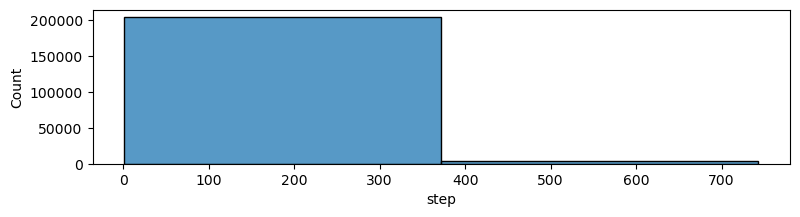

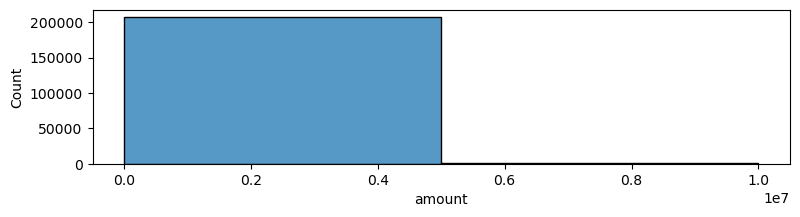

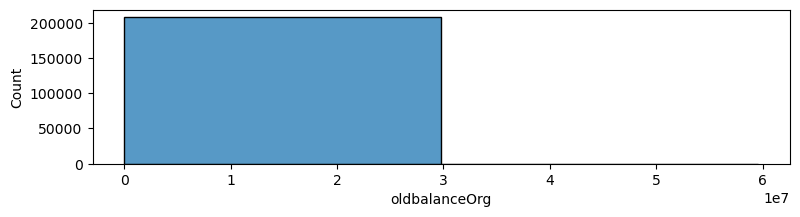

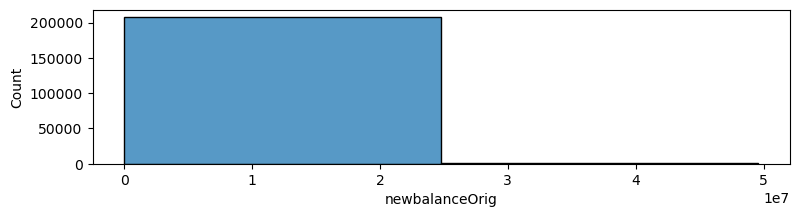

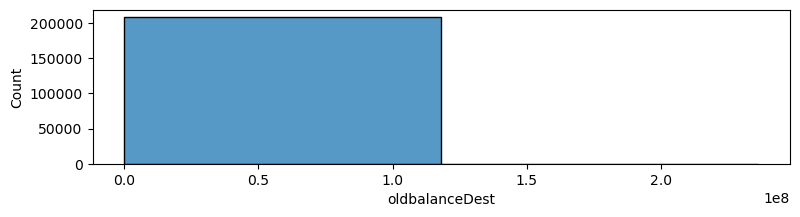

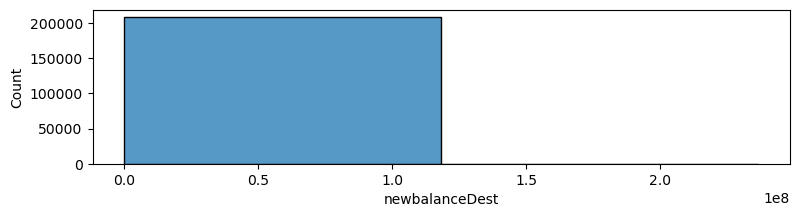

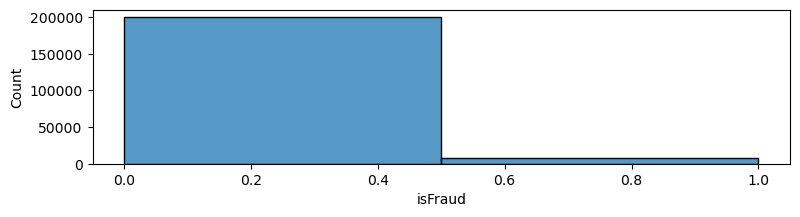

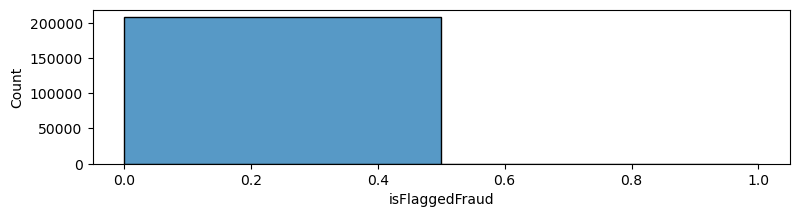

In [31]:
for col in numeric_columns:
    plt.figure(figsize=(9,2))
    sns.histplot(data=df,x=df[col],bins=2)
    plt.show()

In [32]:
df[['step','oldbalanceOrg','newbalanceOrig']].describe()

,step,oldbalanceOrg,newbalanceOrig
count,208213.00,208213.00,208213.00
mean,24.21,912345.38,872604.29
std,81.95,2804991.09,2778976.37
min,1.00,0.00,0.00
25%,9.00,0.00,0.00
50%,10.00,20894.00,0.00
75%,12.00,227866.00,204284.76
max,743.00,59585040.37,49585040.37


In [33]:
df[['oldbalanceDest','newbalanceDest']].describe()

,oldbalanceDest,newbalanceDest
count,208213.00,208213.00
mean,925948.79,1195510.94
std,2419683.44,2715619.94
min,0.00,0.00
25%,0.00,0.00
50%,40958.30,128019.46
75%,738531.50,1186317.31
max,236230516.82,236726494.66


### Analyze categorical features

In [34]:
df.select_dtypes(exclude=['float64','int64']).columns

Index(['transaction_type', 'nameOrig', 'nameDest'], dtype='object')

In [35]:
# Unique Identifers:
df[['nameOrig','nameDest']].describe()

,nameOrig,nameDest
count,208213,208213
unique,208208,102590
top,C44568807,C985934102
freq,2,84


In [36]:
categorical_columns = df.select_dtypes(exclude=['float64','int64']).columns[0] # We will only use transaction type column as categorical because the other columns are unique identifiers.
categorical_columns

'transaction_type'

In [37]:
numeric_columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

## Exploratory Data Analysis

In [38]:
df.head(1)

,step,transaction_type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0


In [39]:
numeric_columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [40]:
categorical_columns

'transaction_type'

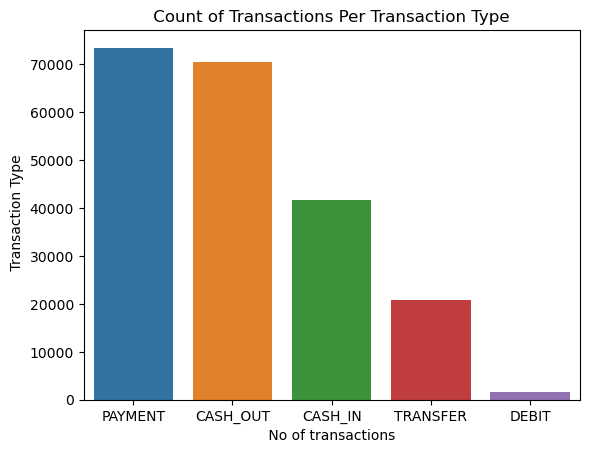

In [41]:
transaction_count = df.groupby('transaction_type')['isFraud'].count().reset_index(name='no of transactions') \
   .sort_values(by='no of transactions',ascending=False)

sns.barplot(data=transaction_count,x='transaction_type',y='no of transactions',)
plt.xlabel(" No of transactions ")
plt.title(" Count of Transactions Per Transaction Type ")
plt.ylabel(" Transaction Type")
plt.show()

### Insights

1. Majority of the Transactions were done by withdrawal of money (CASH OUT) from account
2. Very less transactions are directly (DEBIT) made from the account

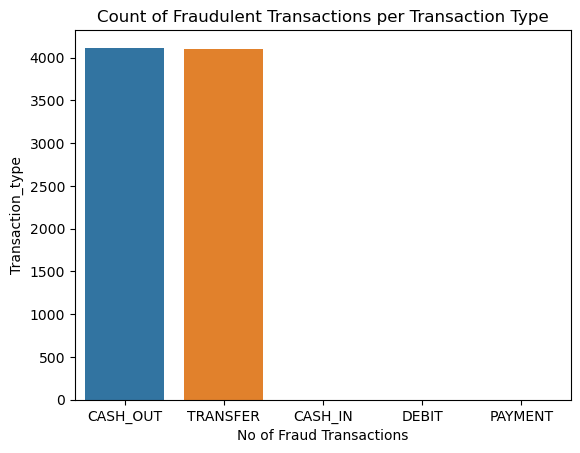

In [42]:
fraud_count_df = df.groupby('transaction_type')['isFraud'].sum().reset_index() \
     .sort_values(by='isFraud',ascending=False) 

sns.barplot(data=fraud_count_df,x='transaction_type',y='isFraud')
plt.title("Count of Fraudulent Transactions per Transaction Type")
plt.xlabel("No of Fraud Transactions")
plt.ylabel("Transaction_type")
plt.show()

### Insights

1. Majortiy of the Fraudulent transaction's were either by (CASH OUT) withdrawal of money from the account or by Transfer of funds between two accounts (TRANSFER).

In [43]:
numeric_columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

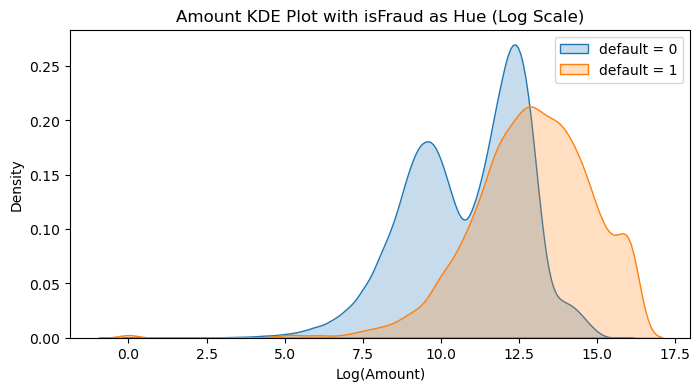

In [44]:
plt.figure(figsize=(8, 4))
sns.kdeplot(np.log1p(df['amount'][df['isFraud'] == 0]), fill=True, label='default = 0')
sns.kdeplot(np.log1p(df['amount'][df['isFraud'] == 1]), fill=True, label='default = 1')
plt.title("Amount KDE Plot with isFraud as Hue (Log Scale)")
plt.xlabel("Log(Amount)")
plt.legend()
plt.show()

#### Insights:

1. We can see that Transactions with higher amount have chances of beign FRAUDULENT.
2. Transactions with smaller amount tend to being NON-FRAUDULENT

In [45]:
numeric_columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

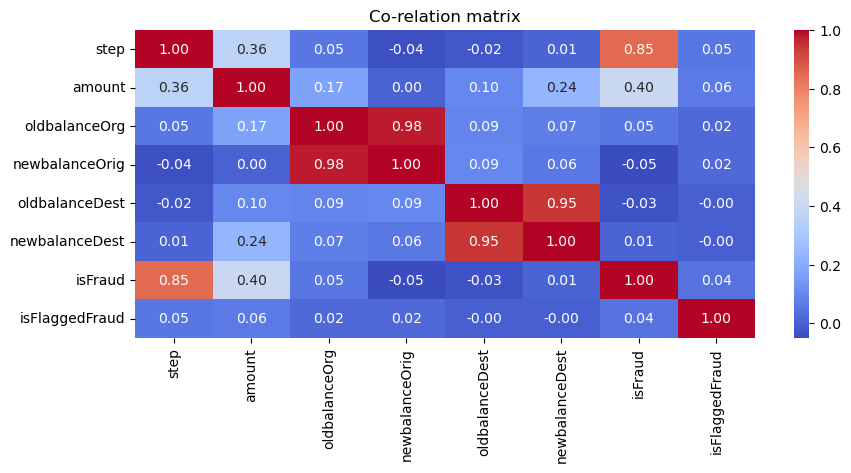

In [46]:
cm = df[numeric_columns].corr()

plt.figure(figsize=(10,4))
sns.heatmap(cm,annot=True,fmt=".2f",cmap='coolwarm')
plt.title("Co-relation matrix")
plt.show()

### Insights from EDA.

1. Most of the transactions took place by CASH OUT , PAYMENT and CASH IN
2. Majority of the FRAUDULENT Transactions took place by CASH OUT or TRANSFER Transaction Type
3. Higher the Amount of Transaction, Higher the Risk of it being Fraud.


## Feature Engineering , Feature Selection

In [47]:
df.head(2)

,step,transaction_type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
1,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0


#### Removing columns based on Domain knowledge

In [48]:
df.drop(columns=['nameOrig','nameDest','isFlaggedFraud'],inplace=True)

In [49]:
df.head(1)

,step,transaction_type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1


#### Scaling

In [50]:
# df_scaled = df.copy()

In [51]:
# cols_to_scale = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

# scaler = RobustScaler()

# df_scaled[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [52]:
# df_scaled.head(2)

# Feature Encoding

In [53]:
# df_scaled.head(1)

In [54]:
# df_scaled['transaction_type'] = df_scaled['transaction_type'].map({"CASH_OUT": 1, "PAYMENT": 2, 
#                                  "CASH_IN": 3, "TRANSFER": 4,
#                                  "DEBIT": 5})
# df_scaled.head(3)

In [55]:
# corelation_scaled = df_scaled.corr()
# print(corelation_scaled['isFraud'].sort_values(ascending=False))

In [56]:
df['transaction_type'] = df['transaction_type'].map({"CASH_OUT": 1, "PAYMENT": 2, 
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})
df.head(3)

,step,transaction_type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,4,181.00,181.00,0.00,0.00,0.00,1
1,1,1,181.00,181.00,0.00,21182.00,0.00,1
2,1,4,2806.00,2806.00,0.00,0.00,0.00,1


In [57]:
cm = df.corr()
cm

,step,transaction_type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
step,1.00,0.07,0.36,0.05,-0.04,-0.02,0.01,0.85
transaction_type,0.07,1.00,0.19,0.25,0.26,0.05,0.05,0.08
amount,0.36,0.19,1.00,0.17,0.00,0.10,0.24,0.40
oldbalanceOrg,0.05,0.25,0.17,1.00,0.98,0.09,0.07,0.05
newbalanceOrig,-0.04,0.26,0.00,0.98,1.00,0.09,0.06,-0.05
oldbalanceDest,-0.02,0.05,0.10,0.09,0.09,1.00,0.95,-0.03
newbalanceDest,0.01,0.05,0.24,0.07,0.06,0.95,1.00,0.01
isFraud,0.85,0.08,0.40,0.05,-0.05,-0.03,0.01,1.00


### Train Test Split

In [58]:
X = df[['transaction_type','amount','oldbalanceOrg','newbalanceOrig']]
y = df['isFraud']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# Model Training

## Attempt 1:


#### Without handling Class Imbalance

In [59]:
# Created a function that takes model, train and test data and returns a classification report.

def get_report(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test,y_pred) 
    
    print(report)
    

In [60]:
get_report(LogisticRegression(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     60049
           1       0.53      0.98      0.69      2415

    accuracy                           0.97     62464
   macro avg       0.77      0.97      0.84     62464
weighted avg       0.98      0.97      0.97     62464



In [61]:
get_report(DecisionTreeClassifier(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60049
           1       0.96      0.98      0.97      2415

    accuracy                           1.00     62464
   macro avg       0.98      0.99      0.98     62464
weighted avg       1.00      1.00      1.00     62464



In [62]:
get_report(DecisionTreeClassifier(criterion='entropy',max_depth=15,min_samples_split=30,random_state=42),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60049
           1       0.95      0.99      0.97      2415

    accuracy                           1.00     62464
   macro avg       0.97      0.99      0.98     62464
weighted avg       1.00      1.00      1.00     62464



In [63]:
get_report(RandomForestClassifier(n_estimators=300, 
    max_depth=10, 
    min_samples_leaf=5, 
    min_samples_split=10, 
    class_weight={0:1, 1:5}, 
    max_features='sqrt',
    bootstrap=True,
    random_state=42),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     60049
           1       0.89      0.99      0.94      2415

    accuracy                           0.99     62464
   macro avg       0.94      0.99      0.97     62464
weighted avg       1.00      0.99      0.99     62464



### Insights:

LogiticRegression Model : recall = 0.36 , precision = 0.86

DecsionTreeClassifier Model : recall = 0.86 , precision =0.88

RandomForestClassfier Model : recall = 0.87, precision = 0.90

## Attempt 2:

#### Handling Class Imbalance using Smote, RandomUnderSampler Techniques:

#### Using SMOTE

In [64]:
from imblearn.over_sampling import SMOTE

In [65]:
smt = SMOTE(random_state=42)

X_resampled,y_resampled = smt.fit_resample(X,y)

In [66]:
get_report(LogisticRegression(),X_resampled,y_resampled,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92     60049
           1       0.22      0.99      0.35      2415

    accuracy                           0.86     62464
   macro avg       0.61      0.92      0.64     62464
weighted avg       0.97      0.86      0.90     62464



In [67]:
get_report(DecisionTreeClassifier(),X_resampled,y_resampled,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60049
           1       1.00      1.00      1.00      2415

    accuracy                           1.00     62464
   macro avg       1.00      1.00      1.00     62464
weighted avg       1.00      1.00      1.00     62464



In [68]:
get_report(RandomForestClassifier(),X_resampled,y_resampled,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60049
           1       1.00      1.00      1.00      2415

    accuracy                           1.00     62464
   macro avg       1.00      1.00      1.00     62464
weighted avg       1.00      1.00      1.00     62464



#### Using RandomUnderSampler:

In [69]:
from imblearn.under_sampling import RandomUnderSampler

In [70]:
under_sampler= RandomUnderSampler(random_state=42)

X_under,y_under = under_sampler.fit_resample(X,y)

In [71]:
get_report(LogisticRegression(),X_under,y_under,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      0.85      0.92     60049
           1       0.21      0.99      0.35      2415

    accuracy                           0.86     62464
   macro avg       0.61      0.92      0.64     62464
weighted avg       0.97      0.86      0.90     62464



In [72]:
get_report(DecisionTreeClassifier(),X_under,y_under,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     60049
           1       0.82      1.00      0.90      2415

    accuracy                           0.99     62464
   macro avg       0.91      1.00      0.95     62464
weighted avg       0.99      0.99      0.99     62464



In [73]:
# get_report(RandomForestClassifier(),X_under,y_under,X_test,y_test)

## Model Fine Tuning

In [74]:
best_model = RandomForestClassifier(n_estimators=300, 
    max_depth=10, 
    min_samples_leaf=5, 
    min_samples_split=10, 
    class_weight={0:1, 1:5}, 
    max_features='sqrt',
    bootstrap=True,
    random_state=42)
best_model.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 5}, max_depth=10,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=300, random_state=42)

In [75]:
y_pred = best_model.predict(X_test)

print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     60049
           1       0.89      0.99      0.94      2415

    accuracy                           0.99     62464
   macro avg       0.94      0.99      0.97     62464
weighted avg       1.00      0.99      0.99     62464



### Our Best model is RandomForestClassifier with recall 99% and precision 93%

# Model Evaluation Roc,Auc Curve:

In [76]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
fpr[:5], tpr [:5],thresholds[:5]

(array([0.       , 0.0051458, 1.       ]),
 array([0.        , 0.99461698, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [77]:
auc_score = auc(fpr,tpr)
print(f"Area Under the Curve = {round(auc_score,2)}")

Area Under the Curve = 0.99


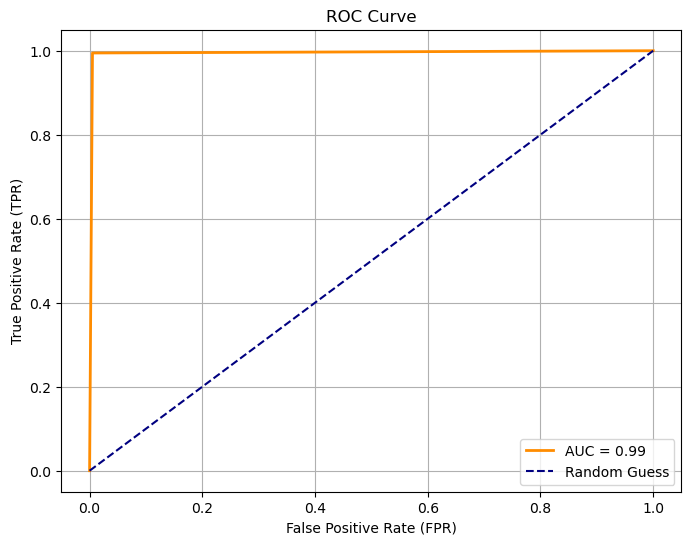

In [78]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guess')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [79]:
X.head(2)

,transaction_type,amount,oldbalanceOrg,newbalanceOrig
0,4,181.00,181.00,0.00
1,1,181.00,181.00,0.00


In [80]:
value = best_model.predict([[1,100023440,200000,25000]])
value
if value== 0:
    print("Not a Fraud")
else:
    print("Fraud")    

Not a Fraud


In [89]:
from joblib import dump

model_data = {
    'model':best_model,
    'features':X_train.columns,
    'label_mapping': {0: 'Not Fraud', 1: 'Fraud'} 
}

dump(model_data, 'c://Users//adinr//Downloads/fraud_detection_model.pkl')


['c://Users//adinr//Downloads/fraud_detection_model.pkl']

In [88]:
import os
print(os.path.exists('c:\\Users\\adinr\\Downloads\fraud_detection_model.pkl'))  # Should return True


False


In [87]:
pwd

'c:\\Users\\adinr\\Downloads\\Online Payment Fraud Detection Project\\online-payment-fraud-detection'